In [9]:
# 1. SETUP ET DÉCOMPRESSION
from google.colab import drive
import os
import zipfile

# Monter le Drive
drive.mount('/content/drive')

# --- CONFIGURATION DES CHEMINS (VERIFIE BIEN LE NOM DU DOSSIER ICI) ---
# Remplace la ligne ci-dessous par le chemin exact copié depuis ton Drive
BASE_PATH = '/content/drive/Shareddrives/Vision-LLM-Project-Team/dataset/raw'

ZIP_PATH = os.path.join(BASE_PATH, 'aligned.zip')
LABEL_FILE = os.path.join(BASE_PATH, 'RAFCE_emolabel.txt')
PARTITION_FILE = os.path.join(BASE_PATH, 'RAFCE_partition.txt')

# Dossier temporaire dans Colab (plus rapide que le Drive)
LOCAL_IMG_DIR = '/content/raf-ce-images'

# Vérification et Décompression
if not os.path.exists(LOCAL_IMG_DIR):
    print(f"📂 Décompression de {ZIP_PATH} vers {LOCAL_IMG_DIR}...")
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(LOCAL_IMG_DIR)
        print("✅ Décompression terminée ! Les images sont prêtes.")
    except FileNotFoundError:
        print("❌ ERREUR : Je ne trouve pas le fichier aligned.zip. Vérifie le chemin BASE_PATH.")
else:
    print("✅ Les images sont déjà décompressées.")

# On cherche où sont tombées les images (souvent dans un sous-dossier 'aligned')
# On scanne pour trouver le dossier qui contient les jpg
FINAL_IMG_DIR = LOCAL_IMG_DIR
for root, dirs, files in os.walk(LOCAL_IMG_DIR):
    if any(f.endswith('.jpg') for f in files):
        FINAL_IMG_DIR = root
        break
print(f"📍 Dossier final des images : {FINAL_IMG_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Décompression de /content/drive/Shareddrives/Vision-LLM-Project-Team/dataset/raw/aligned.zip vers /content/raf-ce-images...
✅ Décompression terminée ! Les images sont prêtes.
📍 Dossier final des images : /content/raf-ce-images/aligned


In [10]:
import os
from google.colab import drive

# 1. Monter le Drive (si pas déjà fait)
drive.mount('/content/drive')

# 2. Définir le chemin EXACT vers le dossier src sur le Drive
PROJECT_FOLDER = 'Vision-LLM-Project-Team'
drive_src_path = f'/content/drive/Shareddrives/{PROJECT_FOLDER}/src'

# Création du dossier au cas où
os.makedirs(drive_src_path, exist_ok=True)
script_path = os.path.join(drive_src_path, 'dataset.py')

print(f"✍️ Mise à jour du fichier sur le Drive : {script_path}")

# 3. Écriture du code (Version Finale)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✍️ Mise à jour du fichier sur le Drive : /content/drive/Shareddrives/Vision-LLM-Project-Team/src/dataset.py


In [5]:
%%writefile "{script_path}"
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import torch
import numpy as np
from collections import Counter

# --- CLASSE DATASET ---
class RAFCEDataset(Dataset):
    def __init__(self, img_dir, label_file, partition_file, split='train', transform=None, return_dict=True):
        self.img_dir = img_dir
        self.transform = transform
        self.return_dict = return_dict

        # Lecture des fichiers
        df_partition = pd.read_csv(partition_file, sep=' ', header=None, names=['image_name', 'partition_label'])
        df_labels = pd.read_csv(label_file, sep=' ', header=None, names=['image_name', 'emotion_label'])

        # Fusion
        df_merged = pd.merge(df_partition, df_labels, on='image_name')
        split_map = {'train': 0, 'test': 1, 'val': 2}
        target = split_map.get(split, 0)
        self.data_info = df_merged[df_merged['partition_label'] == target].reset_index(drop=True)

        # Mapping ID -> Texte
        self.classes = {
            0: "happily surprised", 1: "happily disgusted", 2: "sadly fearful",
            3: "sadly angry", 4: "sadly surprised", 5: "sadly disgusted",
            6: "fearfully angry", 7: "fearfully surprised", 8: "fearfully disgusted",
            9: "angrily surprised", 10: "angrily disgusted", 11: "disgustedly surprised",
            12: "happily fearful", 13: "happily sad"
        }

    def __len__(self):
        return len(self.data_info)

    def get_labels(self):
        return self.data_info['emotion_label'].values

    def __getitem__(self, idx):
        img_name = self.data_info.iloc[idx]['image_name']
        label = int(self.data_info.iloc[idx]['emotion_label'])
        label_text = self.classes.get(label, "unknown")

        possible_names = [img_name, img_name + ".jpg", img_name.replace(".jpg", "") + "_aligned.jpg"]
        img_path = None
        for name in possible_names:
            temp_path = os.path.join(self.img_dir, name)
            if os.path.exists(temp_path):
                img_path = temp_path
                break

        image = Image.open(img_path).convert('RGB') if img_path else Image.new('RGB', (224, 224))

        if self.transform:
            image = self.transform(image)

        if self.return_dict:
            return {"image": image, "label": label, "label_text": label_text}
        else:
            return image, label

def get_dataloaders(img_dir, label_file, partition_file, batch_size=32, use_sampler=True):
    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    eval_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_ds = RAFCEDataset(img_dir, label_file, partition_file, 'train', train_transform)
    val_ds = RAFCEDataset(img_dir, label_file, partition_file, 'val', eval_transform)
    test_ds = RAFCEDataset(img_dir, label_file, partition_file, 'test', eval_transform)

    sampler = None
    shuffle = True
    if use_sampler:
        labels = train_ds.get_labels()
        counts = Counter(labels)
        weights = torch.tensor([1.0/counts[l] for l in labels], dtype=torch.double)
        sampler = WeightedRandomSampler(weights, len(weights))
        shuffle = False

    return (DataLoader(train_ds, batch_size, shuffle=shuffle, sampler=sampler),
            DataLoader(val_ds, batch_size, shuffle=False),
            DataLoader(test_ds, batch_size, shuffle=False))

Overwriting /content/drive/Shareddrives/Vision-LLM-Project-Team/src/dataset.py


📍 Cible : /content/drive/Shareddrives/Vision-LLM-Project-Team/src/dataset.py
✅ Importation 'Force Brute' RÉUSSIE !
✅ Fonction 'get_dataloaders' prête à l'emploi.

🔄 Test de chargement des données...
✅ Batch récupéré avec succès ! Textes : ['sadly angry', 'fearfully surprised', 'sadly fearful', 'sadly angry']


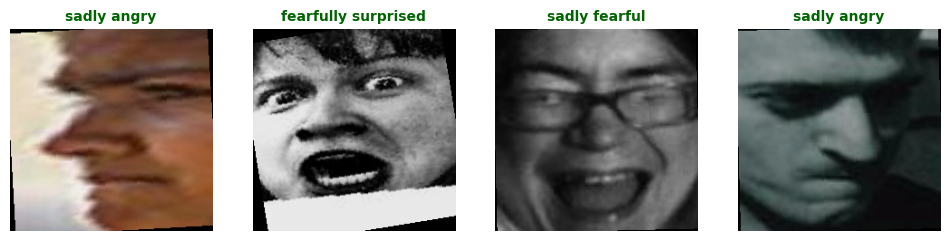

In [11]:
import sys
import os
import importlib.util

# 1. DÉFINITION DU CHEMIN EXACT (Celui que tu as vu dans ton enquête)
# Attention : Python est sensible aux majuscules/minuscules
script_path = '/content/drive/Shareddrives/Vision-LLM-Project-Team/src/dataset.py'

print(f"📍 Cible : {script_path}")

# 2. IMPORTATION FORCÉE (Bypass sys.path)
if os.path.exists(script_path):
    try:
        # On dit à Python : "Prends ce fichier précis et appelle-le 'dataset'"
        spec = importlib.util.spec_from_file_location("dataset", script_path)
        dataset_module = importlib.util.module_from_spec(spec)
        sys.modules["dataset"] = dataset_module
        spec.loader.exec_module(dataset_module)

        print("✅ Importation 'Force Brute' RÉUSSIE !")

        # On récupère la fonction qu'on voulait
        get_dataloaders = dataset_module.get_dataloaders
        print("✅ Fonction 'get_dataloaders' prête à l'emploi.")

    except Exception as e:
        print(f"❌ Erreur critique lors du chargement manuel : {e}")
else:
    print("❌ ERREUR : Le chemin est incorrect. Vérifie l'orthographe exacte dans le panneau de gauche (Fichiers).")

# 3. UTILISATION ET AFFICHAGE (Comme avant)
# Si l'étape 2 a marché, ceci va fonctionner
try:
    # Chemins des données (Ajuste si besoin avec Shareddrives aussi !)
    IMG_DIR = '/content/raf-ce-images/aligned'
    # Attention: Vérifie si tes txt sont dans MyDrive ou Shareddrives !
    # Je mets Shareddrives par défaut vu ton message précédent
    LABEL_FILE = '/content/drive/Shareddrives/Vision-LLM-Project-Team/dataset/raw/RAFCE_emolabel.txt'
    PARTITION_FILE = '/content/drive/Shareddrives/Vision-LLM-Project-Team/dataset/raw/RAFCE_partition.txt'

    print("\n🔄 Test de chargement des données...")
    train_dl, _, _ = get_dataloaders(IMG_DIR, LABEL_FILE, PARTITION_FILE, batch_size=4, use_sampler=True)

    # Affichage
    import matplotlib.pyplot as plt
    import numpy as np

    batch = next(iter(train_dl))
    images = batch['image']
    texts = batch['label_text']

    print(f"✅ Batch récupéré avec succès ! Textes : {texts}")

    # Petit visuel pour fêter ça
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])

    for i, ax in enumerate(axs):
        img = images[i].numpy().transpose((1, 2, 0)) * std + mean
        ax.imshow(np.clip(img, 0, 1))
        ax.set_title(texts[i], color='darkgreen', fontweight='bold', fontsize=10)
        ax.axis('off')
    plt.show()

except Exception as e:
    print(f"\n⚠️ Attention : Le code a chargé mais une erreur est survenue ensuite : {e}")
    print("Vérifie bien que les fichiers TXT sont aussi dans 'Shareddrives' et non 'MyDrive'.")

## Détection et Alignement des Visages

Le jeu de données RAF-CE fournit des images déjà centrées sur le visage et pré-alignées.
Nous avons inspecté visuellement des échantillons aléatoires du dataset et confirmé que les visages sont correctement recadrés et centrés dans la majorité des images.

Par conséquent, aucune étape supplémentaire de détection de visage ou d'alignement (comme MTCNN ou RetinaFace) n'a été appliquée dans ce pipeline de prétraitement.


🔄 Lecture des fichiers...


/tmp/ipython-input-4087422358.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y="Label_Name", data=df_train, order=order, palette="viridis")


✅ Graphique sauvegardé ici : /content/drive/Shareddrives/Vision-LLM-Project-Team/results/distribution_classes.png
Tu peux télécharger cette image pour ton rapport !


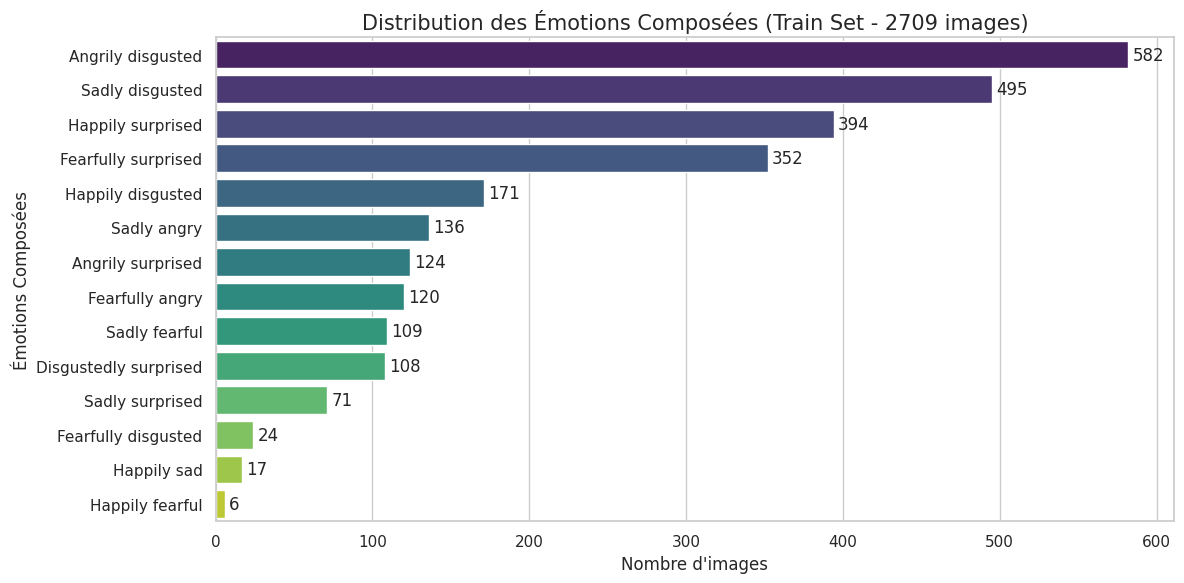

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# --- 1. CONFIGURATION ---
# Chemins (Normalement les mêmes que précédemment)
BASE_PATH = '/content/drive/Shareddrives/Vision-LLM-Project-Team/dataset/raw'
LABEL_FILE = os.path.join(BASE_PATH, 'RAFCE_emolabel.txt')
PARTITION_FILE = os.path.join(BASE_PATH, 'RAFCE_partition.txt')

# Dictionnaire des classes
CLASSES = {
    1: "Happily surprised", 2: "Happily disgusted", 3: "Sadly fearful",
    4: "Sadly angry", 5: "Sadly surprised", 6: "Sadly disgusted",
    7: "Fearfully angry", 8: "Fearfully surprised", 9: "Fearfully disgusted",
    10: "Angrily surprised", 11: "Angrily disgusted", 12: "Disgustedly surprised",
    13: "Happily fearful", 14: "Happily sad"
}
# Note: Les labels dans le fichier txt vont de 1 à 14 ou 0 à 13 selon la version.
# RAF-CE officiel est souvent 1-based dans la doc mais 0-based ou 1-based dans le txt.
# On va vérifier dynamiquement.

# --- 2. CHARGEMENT DES DONNÉES ---
print("🔄 Lecture des fichiers...")
# Lecture des fichiers (sans en-tête)
df_labels = pd.read_csv(LABEL_FILE, sep=' ', header=None, names=['image', 'label'])
df_partition = pd.read_csv(PARTITION_FILE, sep=' ', header=None, names=['image', 'partition'])

# Fusion
df = pd.merge(df_labels, df_partition, on='image')

# Filtrer pour garder uniquement le TRAIN set (Partition 0)
# C'est ce que le modèle va voir, donc c'est le plus important.
df_train = df[df['partition'] == 0].copy()

# Correction des labels si nécessaire (Parfois 0-13, parfois 1-14)
# On mappe pour avoir les noms
# Si tes labels commencent à 0, on ajuste le dictionnaire
if df_train['label'].min() == 0:
    CLASSES = {k-1: v for k, v in CLASSES.items()} # Shift des clés

df_train['Label_Name'] = df_train['label'].map(CLASSES)

# --- 3. GÉNÉRATION DU GRAPHIQUE ---
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Création de l'histogramme trié
order = df_train['Label_Name'].value_counts().index
ax = sns.countplot(y="Label_Name", data=df_train, order=order, palette="viridis")

plt.title(f"Distribution des Émotions Composées (Train Set - {len(df_train)} images)", fontsize=15)
plt.xlabel("Nombre d'images", fontsize=12)
plt.ylabel("Émotions Composées", fontsize=12)

# Ajouter les chiffres au bout des barres
for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.tight_layout()

# --- 4. SAUVEGARDE ---
save_path = '/content/drive/Shareddrives/Vision-LLM-Project-Team/results/distribution_classes.png'
# Créer le dossier results s'il n'existe pas
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=300)

print(f"✅ Graphique sauvegardé ici : {save_path}")
print("Tu peux télécharger cette image pour ton rapport !")
plt.show()

## Gestion du Déséquilibre des Classes

La distribution des classes montre un déséquilibre clair entre les différentes émotions composées.
Pour atténuer ce problème, nous utilisons deux stratégies complémentaires :

1. **WeightedRandomSampler** (déjà implémenté dans notre `DataLoader`) : Cela assure que chaque batch d'entraînement contient un mélange équilibré de classes, évitant que le modèle ne voit que les classes majoritaires.
2. **Pondération des Classes (Class Weighting)** : Nous calculons ci-dessous des poids inverses à la fréquence des classes. Ces poids pourront être passés à la fonction de perte (Loss Function) pour pénaliser davantage les erreurs sur les classes rares.

In [12]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np

# On récupère tous les labels depuis notre dataset d'entraînement
# (Note: train_dl a été créé juste au-dessus via get_dataloaders)
train_labels = train_dl.dataset.get_labels()
classes_unique = np.unique(train_labels)

# Calcul des poids (inversement proportionnels à la fréquence de chaque classe)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes_unique,
    y=train_labels
)

# Conversion en tenseur PyTorch (nécessaire pour la CrossEntropyLoss)
class_weights = torch.tensor(class_weights_array, dtype=torch.float)

print("⚖️ Poids des classes calculés avec succès :")
print(class_weights)
print("\nCes poids sont prêts à être injectés dans la fonction de perte du modèle.")

⚖️ Poids des classes calculés avec succès :
tensor([ 0.4911,  1.1316,  1.7752,  1.4228,  2.7254,  0.3909,  1.6125,  0.5497,
         8.0625,  1.5605,  0.3325,  1.7917, 32.2500, 11.3824])

Ces poids sont prêts à être injectés dans la fonction de perte du modèle.


## Export des Données pour l'Équipe

Ce pipeline de prétraitement est maintenant complet. Il fournit :
- Des images nettoyées et normalisées (gérées via `dataset.py`).
- Les splits Train / Validation / Test.
- Des DataLoaders PyTorch équipés d'un **Sampler** pour l'équilibrage.
- Un dataset prêt pour le **Vision-LLM** incluant les labels textuels (clé `label_text`).

Ces éléments sont prêts à être réutilisés pour :
- L'entraînement du modèle Baseline (ResNet) et du Vision-LLM.
- Les pipelines d'évaluation et d'explicabilité.

In [13]:
import torch
import json
import os

# --- ÉTAPE FINALE : SAUVEGARDE DES MÉTADONNÉES POUR L'ÉQUIPE ---

# Chemin vers le dossier partagé 'results' ou 'dataset'
# On utilise le dossier 'dataset' car c'est une info liée aux données
output_dir = f'/content/drive/Shareddrives/Vision-LLM-Project-Team/dataset'
os.makedirs(output_dir, exist_ok=True)

# 1. Sauvegarde des poids des classes (pour que Person 2 les utilise directement)
weights_path = os.path.join(output_dir, 'class_weights.pt')
torch.save(class_weights, weights_path)
print(f"✅ Poids des classes sauvegardés : {weights_path}")

# 2. Sauvegarde du mapping ID -> Texte (Indispensable pour le Vision-LLM)
# On récupère le mapping depuis le dataset
mapping = train_dl.dataset.classes
mapping_path = os.path.join(output_dir, 'label_mapping.json')

with open(mapping_path, 'w') as f:
    json.dump(mapping, f, indent=4)
print(f"✅ Mapping Label->Texte sauvegardé : {mapping_path}")

print("\n🎉 MISSION ACCOMPLIE !")
print("Le dataset est nettoyé, analysé et prêt. Les métadonnées sont sur le Drive.")
print("Tu peux maintenant passer le relais au Model Lead.")

✅ Poids des classes sauvegardés : /content/drive/Shareddrives/Vision-LLM-Project-Team/dataset/class_weights.pt
✅ Mapping Label->Texte sauvegardé : /content/drive/Shareddrives/Vision-LLM-Project-Team/dataset/label_mapping.json

🎉 MISSION ACCOMPLIE !
Le dataset est nettoyé, analysé et prêt. Les métadonnées sont sur le Drive.
Tu peux maintenant passer le relais au Model Lead.
